### *PhotoDissociation Region Toolbox Notebooks*
-------------------------------------------------------------

# Example 4: Image Radiation Field and Density

This Example shows use the PDRT Toolbox to determine the PDR radiation field $G_0$ and hydrogen nucleus volume density $n$ from your spectral line and far-infrared (FIR) data into the PDR Toolbox.  The example shows how to make maps of $G_0$ and $n$ from your maps of observables. If you have not gone through the Measurements and ModelSets examples, you should do them first.

###   Radiation Field and Density from Image Measurements
Following the example on how to use Measurements, create Measurements for your image observations. Here we use the N22 [C II], [O I], and FIR maps from [Jameson et al. 2018](https://ui.adsabs.harvard.edu/abs/2018ApJ...853..111J/abstract). 

In [1]:
from pdrtpy.measurement import Measurement
from pdrtpy.modelset import ModelSet
import pdrtpy.pdrutils as utils
from pdrtpy.tool.lineratiofit import LineRatioFit
from pdrtpy.plot.lineratioplot import LineRatioPlot
import astropy.units as u
import numpy as np

/home/mpound/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:1161: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(), op)(other)


In [2]:
# check that your notebooks align with your pdrtpy version
utils.check_nb()

Your PDRT notebooks version matches your pdrtpy version -- hooray!


In [3]:
# Get the input filenames of the FITS files in the testdata directory
# utils.get_testdata() is a special method to locate files there.
# These are maps from Jameson et al 2018.
print("Test FITS files are in: %s"%utils.testdata_dir())
cii_flux = utils.get_testdata("n22_cii_flux.fits")  # [C II] flux
cii_err = utils.get_testdata("n22_cii_error.fits")  # [C II] error
oi_flux = utils.get_testdata("n22_oi_flux.fits")    # [O I] flux 
oi_err = utils.get_testdata("n22_oi_error.fits")    # [O I] error
FIR_flux = utils.get_testdata("n22_FIR.fits")       # FIR flux

# Output file names
cii_combined = "n22_cii_flux_error.fits"
oi_combined = "n22_oi_flux_error.fits"
FIR_combined = "n22_FIR_flux_error.fits"

# create the Measurements and write them out as FITS files with two HDUs.
# Set overwrite=True to allow multiple runs of this notebook.
Measurement.make_measurement(cii_flux, cii_err, cii_combined,overwrite=True)
Measurement.make_measurement(oi_flux, oi_err, oi_combined,overwrite=True)
# Assign a 10% error in FIR flux
Measurement.make_measurement(FIR_flux, error='10%', outfile=FIR_combined,overwrite=True)

# Read in the FITS files to Measurements
cii_meas = Measurement.read(cii_combined, identifier="CII_158")
FIR_meas = Measurement.read(FIR_combined, identifier="FIR")
oi_meas = Measurement.read(oi_combined, identifier="OI_63")

Test FITS files are in: /home/mpound/src/release_branch/pdrtpy/pdrtpy/testdata/


#### Import the `Measurements` into the LineRatioFit tool
Here we will use the Small Magellanic Cloud models that have Z=0.1 rather than the standard set. Note these are a limited set of models with just a few lines covered.

In [4]:
smcmod = ModelSet("smc",z=0.1)
p = LineRatioFit(modelset=smcmod,measurements=[cii_meas,FIR_meas,oi_meas])
smcmod.table.show_in_notebook()

### Now run it! 
This example sets no data mask. However the default behavior is to compute the standard deviation of the data using the median absolute deviation, and then masking out values between $\pm 1 \sigma$. (`mask=['mad',1.0]`).   You can try running this notebook without the mask keyword given, i.e., `p.run()`,to see how this works.

In [5]:
p.run(mask=None)

### The results are stored in member variables as Measurements.
In this case they are two-dimensional maps with NaN in the blank pixels.

In [6]:
print(p.density.shape,p.radiation_field.shape)
print("Mean density: %.1E %s"%(np.nanmean(p.density),p.density.unit))
print("Mean radiation field: %.1E %s"%(np.nanmean(p.radiation_field),p.radiation_field.unit))

(139, 81) (139, 81)
Mean density: 6.0E+03 1 / cm3
Mean radiation field: 5.8E+01 Habing


### OK let's plot some maps!
Instantiate a plotter and call the same methods as in the single pixel case.

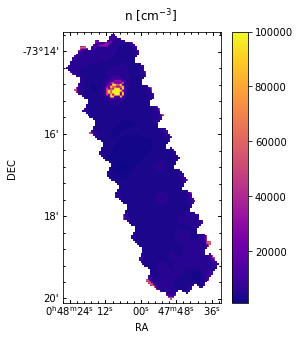

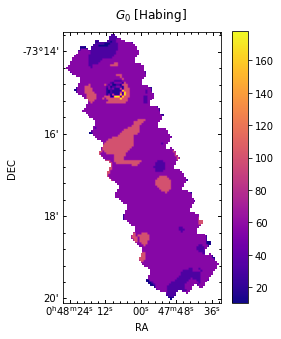

In [7]:
plot = LineRatioPlot(p)
plot.density()
plot.radiation_field()

In [8]:
plot._axis[0].coords[1].display_minor_ticks(True)

 #### You can change the units of the image.

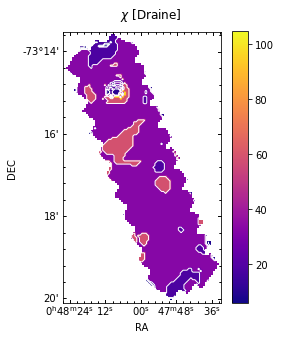

In [9]:
plot.radiation_field(units='Draine',contours=True)

### The minimum reduced $\chi^2$ as a function of RA-DEC

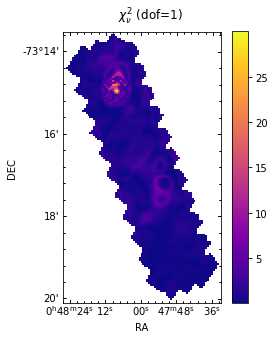

In [10]:
plot.reduced_chisq(contours=False,norm='simple')

## You can easily write out radiation field, density, and   $\chi^2$ as FITS files.
This uses the standard astropy fits I/O.

In [11]:
# use overwrite to make re-running this notbook easier
p.radiation_field.write("myradiationfield.fits",overwrite=True)
p.density.write("mydensity.fits",overwrite=True)
p.write_chisq(chi="chisq.fits",rchi="reduced_chisq.fits",overwrite=True)

#### You can show both $G_0$ and $n$ side by side with `show_both`.

(None, None)

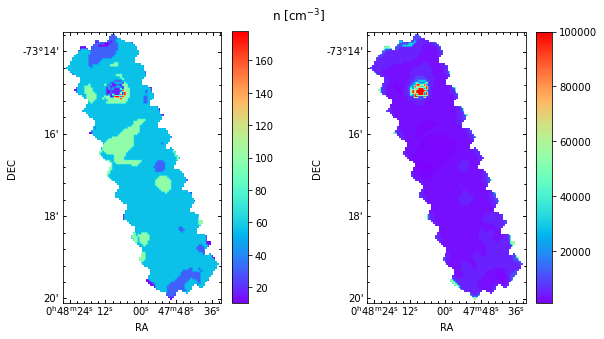

In [12]:
plot.show_both(cmap='rainbow',norm=None)

Compare these to the rightmost panels of [Figure 14](https://iopscience.iop.org/article/10.3847/1538-4357/aaa4bb#apjaaa4bbf14) of  [Jameson et al. 2018](https://ui.adsabs.harvard.edu/abs/2018ApJ...853..111J/abstract) (ignoring colormap differences which aren't a one-to-one match).

![G0 and n from Jameson et al. 2018](jameson.png)

Now, Jameson et al. massaged their maps to decimate oversampled pixels and fix jumps in adjacent pixels.  We can get closer to that with a bit of smoothing.

In [13]:
from astropy.convolution import Box2DKernel, convolve
kernel = Box2DKernel(9,mode='center')
convrf = convolve(p.radiation_field, kernel)
convn = convolve(p.density,kernel)

#### Replace the data with the convolved data and replot. 

In [14]:
p.radiation_field.data = convrf
p.density.data = convn

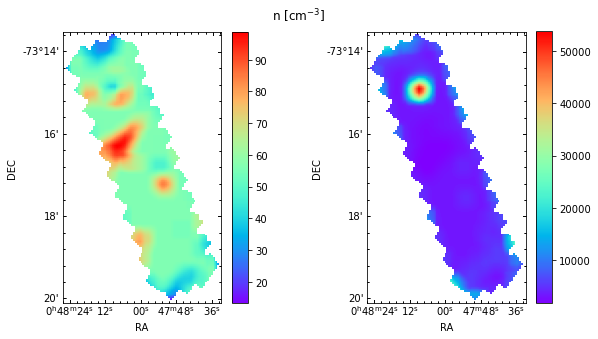

In [15]:
xx=plot.show_both(cmap='rainbow',norm='zscale')
plot.savefig("both.png",bbox_inches='tight')

#### That's closer to the published result.

In [16]:
# Don't like the result? Just run the tool again to reset it!
p.run(mask=None)